<a href="https://colab.research.google.com/github/domzylka/Basic_projects/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Project

The aim of the project is to develop information on the punctuality of Polish trains (identify the least punctual routes/trains, analysis of outliers), create a map of connections between stations and develop the most optimal courses using ML techniques.

## Part 1 - Train delay analysis


Given the size of the data (more than 19 million records), choosing Spark here is the only sensible option.

In [1]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=09dc02a6a21c9f42ccc52ec52236ce03b24e923e253fe1d04e9765abc2910395
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import avg, to_date, year
from pyspark.sql.functions import dayofyear
from pyspark.sql.functions import month, quarter

In [3]:
#Creating Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Data taken from: http://ipa.lovethosetrains.com/

1.   df file contains information about departures and arrivals of trains from/at given stations along with train numbers
2.   df1 file contains information about the numbers and names of trains and stations they pass through

In [4]:
#Importing files from Google Drive
df = spark.read.format("json").load("/content/drive/MyDrive/Colab Notebooks/Projekt PKP/api/train/")
df1 = spark.read.json("/content/drive/MyDrive/Colab Notebooks/Projekt PKP/trains.json")

In [5]:
print('DF:')
display(df.show())
print('DF1:')
display(df1.show())

DF:
+--------------------+--------+-----------------+
|           schedules|train_id|       train_name|
+--------------------+--------+-----------------+
|[{[{null, null, 0...|    1201|          22630/1|
|[{[{null, null, 0...|     883|          22618/9|
|[{[{null, null, 0...|     692|          22648/9|
|[{[{null, null, 0...|    1556|          22632/3|
|[{[{null, null, 0...|     477|          22614/5|
|[{[{null, null, 0...|    1911|          22636/7|
|[{[{null, null, 0...|     346|          22612/3|
|[{[{null, null, 0...|     153|   17501/0 PROSNA|
|[{[{null, null, 0...|     291|  71502/3 LUTYNIA|
|[{[{null, null, 0...|    1123|  17219/8 LUTYNIA|
|[{[{null, null, 0...|     889|          12552/3|
|[{[{null, null, 0...|     682|          12550/1|
|[{[{null, null, 0...|    1055|          34800/1|
|[{[{null, null, 0...|    1842|   71204/5 PROSNA|
|[{[{null, null, 0...|     245|43800/1 KAROLINKA|
|[{[{null, null, 0...|    1586|          32318/9|
|[{[{null, null, 0...|      54|          23312

None

DF1:
+--------------------+
|              trains|
+--------------------+
|[{[Dominów, Lubli...|
+--------------------+



None

In [6]:
row_count = df.count()
row_count1 = df1.count()
print("Number of rows in the table:", row_count)
print("Number of rows in the table1:", row_count1)

Number of rows in the table: 5684
Number of rows in the table1: 1


In [7]:
#Displaying the structures of both files
display(df.printSchema())
print('\n')
display(df1.printSchema())

root
 |-- schedules: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- info: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- arrival_delay: long (nullable = true)
 |    |    |    |    |-- arrival_time: string (nullable = true)
 |    |    |    |    |-- departure_delay: long (nullable = true)
 |    |    |    |    |-- departure_time: string (nullable = true)
 |    |    |    |    |-- station_name: string (nullable = true)
 |    |    |-- schedule_date: string (nullable = true)
 |    |    |-- schedule_id: long (nullable = true)
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)



None



root
 |-- trains: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- stations: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- train_name: string (nullable = true)



None

In [8]:
#Clearing first file

#Explode "schedules" column
df_exploded = df.select(
    "train_id",
    "train_name",
    explode("schedules").alias("schedule")
)

df_final = df_exploded.select(
    "train_id",
    "train_name",
    "schedule.schedule_id",
    "schedule.schedule_date",
    "schedule.info"
)

#Explode "info" column
df_info_exploded = df_final.select(
    "train_id",
    "train_name",
    "schedule_id",
    "schedule_date",
    explode("info").alias("info")
)

df_result = df_info_exploded.select(
    "train_id",
    "train_name",
    "schedule_id",
    "schedule_date",
    "info.arrival_delay",
    "info.arrival_time",
    "info.departure_delay",
    "info.departure_time",
    "info.station_name"
)

df_result.show()

+--------+----------+-----------+-------------+-------------+-------------------+---------------+-------------------+--------------------+
|train_id|train_name|schedule_id|schedule_date|arrival_delay|       arrival_time|departure_delay|     departure_time|        station_name|
+--------+----------+-----------+-------------+-------------+-------------------+---------------+-------------------+--------------------+
|    1201|   22630/1|  108322598|   2022-12-10|         null|               null|              0|2022-12-10T15:29:00|              Dęblin|
|    1201|   22630/1|  108322598|   2022-12-10|            0|2022-12-10T15:33:00|              0|2022-12-10T15:33:30|      Rokitnia Stara|
|    1201|   22630/1|  108322598|   2022-12-10|            2|2022-12-10T15:37:00|              2|2022-12-10T15:37:30|              Życzyn|
|    1201|   22630/1|  108322598|   2022-12-10|            2|2022-12-10T15:40:00|              2|2022-12-10T15:40:30|                Mika|
|    1201|   22630/1|  1083

In [9]:
#Clearing second file

df1_exploded = df1.select(explode("trains").alias("train"))

df1_final = df1_exploded.select(
    df1_exploded["train.train_name"].alias("train_name"),
    df1_exploded["train.stations"].alias("stations")
)

df1_final.show(truncate=False)

+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|train_name             |stations                                                                                                                                                                                                                                                                                                                                                                    |
+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
#Joing both tables on 'train_name'
df_all = df_result.join(df1_final, "train_name")

df_all.show(truncate=False)

+----------+--------+-----------+-------------+-------------+-------------------+---------------+-------------------+--------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
#Searching for null values
null_counts = df_all.select([sum(col(c).isNull().cast("integer")).alias(c) for c in df_all.columns])

null_counts.show()

+----------+--------+-----------+-------------+-------------+------------+---------------+--------------+------------+--------+
|train_name|train_id|schedule_id|schedule_date|arrival_delay|arrival_time|departure_delay|departure_time|station_name|stations|
+----------+--------+-----------+-------------+-------------+------------+---------------+--------------+------------+--------+
|         0|       0|          0|            0|       950163|      950163|         952913|        952913|           0|       0|
+----------+--------+-----------+-------------+-------------+------------+---------------+--------------+------------+--------+



In [12]:
# Filtrowanie wartości arrival_delay większych niż 5 minut
df_filtered = df_all.filter(col("arrival_delay") > 0)

# Konwersja DataFrame do pandas DataFrame
df_pandas = df_filtered.select(col("arrival_delay")).toPandas()

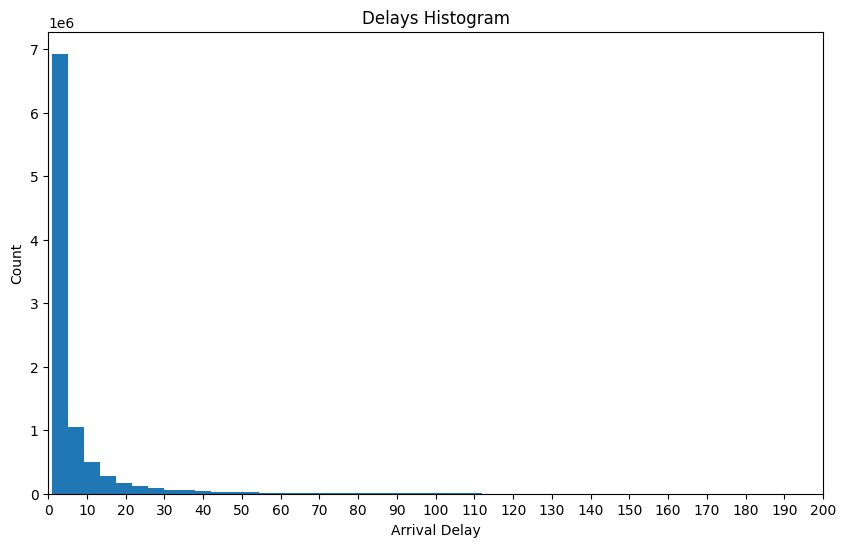

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df_pandas["arrival_delay"], bins=600)

#Plotting
plt.title("Delays Histogram")
plt.xlabel("Arrival Delay")
plt.ylabel("Count")
plt.xlim(0, 200)
plt.xticks(range(0, 201, 10))
plt.show()

In [14]:
from pyspark.sql.functions import expr

#Wyliczenie średnich opóźnień w ciągu roku z podziałem na dni

# Wyodrębnienie numeru dnia w roku
df = df_all.withColumn("day_of_year", dayofyear(df_all["departure_time"]))

# Obliczanie średnich opóźnień dla każdego dnia w roku
df_avg = df.groupBy("day_of_year").agg(avg("departure_delay").alias("avg_delay")).orderBy("day_of_year")

# Pobieranie numerów dni w roku do osi x
day_of_year = df_avg.select("day_of_year").rdd.flatMap(lambda x: x).collect()

# Pobieranie średnich opóźnień do osi y
avg_delays = df_avg.select("avg_delay").rdd.flatMap(lambda x: x).collect()

# Obliczanie mediany ogólnej opóźnień dla całego roku
overall_median_delay = df_avg.agg(expr("percentile_approx(avg_delay, 0.5)")).collect()[0][0]


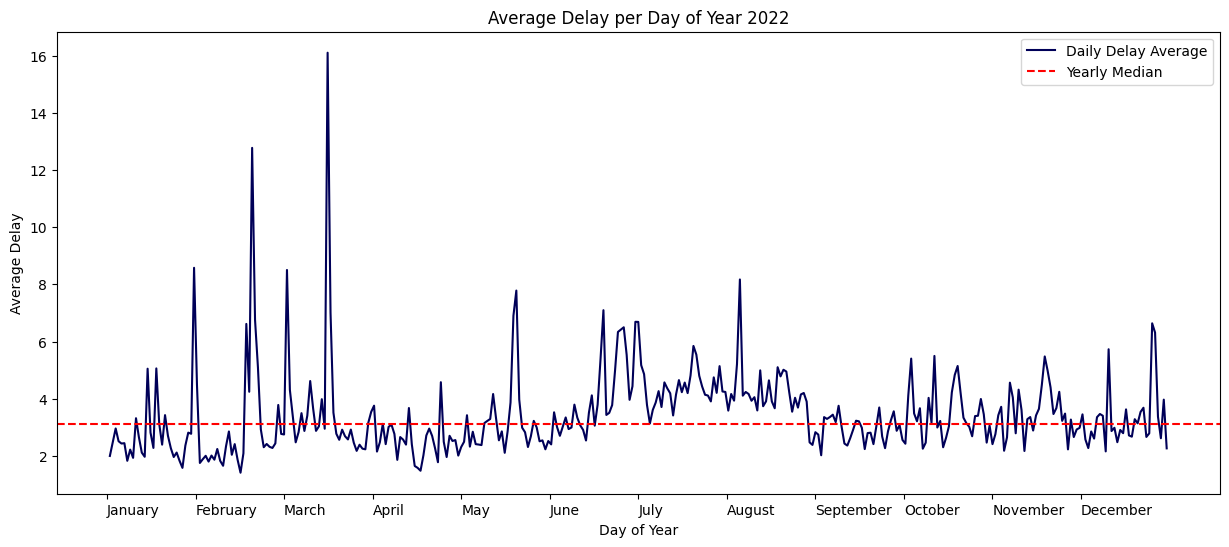

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(day_of_year, avg_delays, color='#000058', label='Daily Delay Average')
plt.axhline(y=overall_median_delay, color='r', linestyle='--', label='Yearly Median')

plt.xlabel("Day of Year")
plt.ylabel("Average Delay")
plt.title("Average Delay per Day of Year 2022")
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(np.arange(0, 366, 30.5), months, horizontalalignment='left')

#plt.box(False)
plt.legend()
plt.show()

In [16]:
# # Wyodrębnienie numeru miesiąca
# df = df_all.withColumn("month", month(df_all["departure_time"]))

# # Obliczanie średnich opóźnień dla każdego miesiąca
# df_avg = df.groupBy("month").agg(avg("departure_delay").alias("avg_delay")).orderBy("month")

# # Pobieranie numerów miesięcy do osi x
# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# month_numbers = range(1, 13)
# month_labels = [months[i-1] for i in month_numbers]

# # Pobieranie średnich opóźnień do osi y
# avg_delays = df_avg.select("avg_delay").rdd.flatMap(lambda x: x).collect()

# plt.figure(figsize=(10, 6))
# plt.plot(month_numbers, avg_delays, color='#000058', marker='o', label='Monthly Average')

# plt.xlabel("Month")
# plt.ylabel("Average Delay")
# plt.title("Average Delay per Month in 2022")
# plt.xticks(month_numbers, month_labels, rotation='vertical')

# plt.legend()
# plt.show()


**dodac procent % ktore przyjechaly na czas**

In [17]:
# Filtrowanie wartości arrival_delay mniejszych niż 5 minut (brak spóźnienia)
df_filtered_arrival = df_all.filter(col("arrival_delay") < 5).count()
df_filtered_departure = df_all.filter(col("departure_delay") < 5).count()

df_filtered_arrival_on_time = df_all.count()

# Konwersja DataFrame do pandas DataFrame
percentage_arrival_on_time = df_filtered_arrival/df_filtered_arrival_on_time
percentage_departure_on_time = df_filtered_departure/df_filtered_arrival_on_time

print(percentage_arrival_on_time)
print(percentage_departure_on_time)

0.794443212589317
0.7962111266405635


## Część 2 - Wizualizacja na mapie

Źródło  https://data.opendatasoft.com/explore/dataset/europe-railway-station%40public/export/?refine.icc=PL


In [18]:
!pip3 install geopy

In [19]:
# Zliczenie różnych nazw stacji
stations_count = df_all.select(col("station_name")).distinct().count()
print("Liczba rożnych stacji:", stations_count)

Liczba rożnych stacji: 2355


In [20]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import split


# Wczytanie pliku CSV z lokalizacjami
df_locations = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Projekt PKP/polish_stations_coordinates.csv", header=True, sep=";")


# Przekonwertowanie kolumny "lokalizacja" na współrzędne x i y
df_locations = df_locations.withColumn("x_y", split(col("Geo Point"), ","))
df_locations = df_locations.withColumn("latitude", col("x_y").getItem(0).cast(FloatType()))
df_locations = df_locations.withColumn("longitude", col("x_y").getItem(1).cast(FloatType()))


df_locations = df_locations.select("latitude", "longitude", "NAMN1")
df_locations.show(truncate=False)

+---------+---------+---------------+
|latitude |longitude|NAMN1          |
+---------+---------+---------------+
|51.5497  |15.446877|Małomice       |
|51.525955|17.295328|Milicz         |
|49.807   |18.5967  |Pogwizdów      |
|50.882027|18.42511 |Olesno Śląskie |
|51.27442 |18.333876|Czastary       |
|51.596027|16.18188 |Grębocice      |
|53.635296|15.626482|Łobez          |
|50.974106|16.358799|Strzegom       |
|49.668915|19.379618|Paweł Wielki   |
|53.418602|14.549815|Szczecin Główny|
|52.175755|22.06627 |Kotuń          |
|50.552044|21.158459|Staszów        |
|52.222733|21.35159 |Halinów        |
|50.67005 |18.206593|Ozimek         |
|50.66703 |18.900206|Boronów        |
|54.106033|22.94395 |Suwałki        |
|51.891582|17.734417|Kowalew        |
|52.842583|17.49715 |Damasławek     |
|52.346237|21.23758 |Wołomin        |
|51.741547|18.06824 |Kalisz         |
+---------+---------+---------------+
only showing top 20 rows



In [21]:
import pyspark.sql.functions as F

old_df = df_all.select("station_name","arrival_delay", "departure_delay")

old_df = old_df.withColumn("is_starting_station", F.when(F.col("arrival_delay").isNull(), True).otherwise(False))
old_df = old_df.withColumn("is_ending_station", F.when(F.col("departure_delay").isNull(), True).otherwise(False))

# Wyświetlenie zmodyfikowanej tabeli
old_df.show()

+--------------------+-------------+---------------+-------------------+-----------------+
|        station_name|arrival_delay|departure_delay|is_starting_station|is_ending_station|
+--------------------+-------------+---------------+-------------------+-----------------+
|              Dęblin|         null|              0|               true|            false|
|      Rokitnia Stara|            0|              0|              false|            false|
|              Życzyn|            2|              2|              false|            false|
|                Mika|            2|              2|              false|            false|
|              Wygoda|            2|              2|              false|            false|
|            Grabniak|            3|              3|              false|            false|
|             Sobolew|            3|              3|              false|            false|
|            Leokadia|            4|              4|              false|            false|

In [22]:
#sprawdzic ile jest null (znaczy ile stacji mu brakuje oraz sprawdzic czy te stacje sa istontne/ ile kursow tam jest) nowy excel pobrany o wymianie pasazerow



In [23]:
import folium
from folium.plugins import MarkerCluster
import requests
import json

mapa = folium.Map(location=[52.237049, 21.017532], zoom_start=8, control_scale=True, tiles=None, width=750, height=750, zoom_control=False, scrollWheelZoom=False, dragging=False)

# Pobranie granic Polski jako obiekt GeoJSON
url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/POL.geo.json"
response = requests.get(url)
poland_geojson = json.loads(response.text)

# Dodanie obrysu Polski jako warstwy GeoJSON
folium.GeoJson(poland_geojson, name="Obrys Polski").add_to(mapa)

for row in df_locations.collect():
    station_name = row["NAMN1"]
    latitude = row["latitude"]
    longitude = row["longitude"]

    # Dodanie  znacznika na mapie
    folium.CircleMarker([latitude, longitude], popup=station_name,radius=2, color="black", fill=True, fill_color="black", fill_opacity=0.8).add_to(mapa)

# Automatyczne dopasowanie widoku mapy do rozmiaru znaczników
mapa.fit_bounds(mapa.get_bounds())

# Wyświetlenie mapy
mapa

In [24]:
# # Iteracja przez kombinacje stacji
# distinct_stations = old_df.select("stations").distinct()

In [25]:
# distinct_stations.show(truncate=False)

In [26]:
import folium
from pyspark.sql.functions import col


# Utworzenie mapy Polski
mapa = folium.Map(location=[52.237049, 21.017532], zoom_start=6)

# Dodanie markerów dla stacji kolejowych z lokalizacjami
for row in df_locations.collect():
    if row["latitude"] and row["longitude"]:
        folium.Marker([float(row["latitude"]), float(row["longitude"])], popup=row["NAMN1"]).add_to(mapa)

# Przetworzenie danych i dodanie linii połączeń na mapę
lat, lon = None, None  # Inicjalizacja zmiennych przechowujących poprzednią lokalizację
prev_is_ending_station = False  # Informacja, czy poprzednia stacja była stacją końcową

## Część 3 - Optymalizacja połączeń